# Notebook to generate NHP data motion correction plots

Be sure to have downloaded and un-zipped the NHP datasets before running this
notebook.

In [8]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from scipy import interpolate as scipy_interpolate

In [9]:
"""Helper functions."""

MONKEY_DATASETS_DIR = Path('../cache/nhp_datasets')
DATASET_NAMES = [
    'Perle_2022-06-06',
    'Perle_2022-06-09',
    'Perle_2022-05-01',
    'Elgar_2022-08-24',
]

def load_data(dataset_name, sampling_frequency, stride=30):
    # Load peak depths, times, and amplitudes
    dataset_dir = MONKEY_DATASETS_DIR / dataset_name
    peak_locations = np.load(dataset_dir / 'peak_locations.npy')
    peak_locations = np.array([x.tolist() for x in peak_locations])
    peak_locations = dict(
        x=peak_locations[:, 0],
        y=peak_locations[:, 1],
        z=peak_locations[:, 2],
        alpha=peak_locations[:, 3],
    )
    peak_depths = peak_locations['y']
    peaks = np.load(dataset_dir / 'peaks.npy')
    peaks = np.array([x.tolist() for x in peaks])
    peaks = dict(
        sample_index=peaks[:, 0],
        channel_index=peaks[:, 1],
        amplitude=peaks[:, 2],
        segment_index=peaks[:, 3],
    )
    peak_amplitudes = peaks['amplitude']
    peak_times = peaks['sample_index'] / sampling_frequency

    # Stride to reduce number of points plotted
    peak_times_plot = peak_times[::stride]
    peak_depths_plot = peak_depths[::stride]
    peak_amplitudes_plot = -1 * peak_amplitudes[::stride]
    
    return peak_times_plot, peak_depths_plot, peak_amplitudes_plot


def get_motion(dataset_name, motion_estimation_method):
    motion_dir = MONKEY_DATASETS_DIR / dataset_name / 'motion_estimation' / motion_estimation_method
    depth_bins = np.load(motion_dir / 'depth_bins.npy')
    time_bins = np.load(motion_dir / 'time_bins.npy')
    motion = np.load(motion_dir / 'motion.npy')
    if motion.ndim == 3:
        if motion.shape[0] == 1:
            motion = motion[0]
        elif motion.shape[1] == 1:
            motion = motion[:, 0]
    if time_bins.ndim == 2 and time_bins.shape[0] == 1:
        time_bins = time_bins[0]
    return depth_bins, time_bins, motion


def correct_motion_on_peaks(peak_times,
                            peak_depths,
                            motion,
                            time_bins,
                            depth_bins):
    corrected_peak_depths = peak_depths.copy()
    f = scipy_interpolate.RegularGridInterpolator(
        (time_bins, depth_bins),
        motion,
        method='linear',
        bounds_error=False,
        fill_value=None,
    )
    shift = f(np.c_[peak_times, peak_depths])
    corrected_peak_depths -= shift

    return corrected_peak_depths


def plot_motion(dataset_name, axes):

    peak_times, peak_depths, peak_amplitudes = load_data(
        dataset_name, sampling_frequency=32000)
    depth_bins, time_bins, motion = get_motion(dataset_name, 'medicine')
        
    if dataset_name == 'Elgar_2022-08-24':
        min_amplitude = 50
        xlim = (4000, 8000)
        ylim = (500, 3500)
        stride = 3
    elif dataset_name == 'Perle_2022-06-06':
        min_amplitude = 0
        xlim = (0, 8000)
        ylim = (1000, 2000)
        stride = 1
    elif dataset_name == 'Perle_2022-06-09':
        min_amplitude = 30
        xlim = (2000, 10000)
        ylim = (1000, 3000)
        stride = 5
    elif dataset_name == 'Perle_2022-05-01':
        min_amplitude = 30
        xlim = (0, 7000)
        ylim = (0, 2500)
        stride = 5
    else:
        raise ValueError(f'Unknown dataset name {dataset_name}')

    peak_amplitudes[peak_amplitudes > 100] = 100
    min_peak_amp = min(peak_amplitudes)
    max_peak_amp = max(peak_amplitudes)
    
    # Filter for and correct peak amplitudes
    keep_indices = peak_amplitudes > min_amplitude
    peak_times = peak_times[keep_indices]
    peak_depths = peak_depths[keep_indices]
    peak_amplitudes = peak_amplitudes[keep_indices]
    peak_amplitudes -= min_amplitude
    peak_amplitudes *= (100 / (100 - min_amplitude))
    
    # Filter peak times
    keep_indices = (peak_times > xlim[0]) * (peak_times < xlim[1])
    peak_times = peak_times[keep_indices]
    peak_depths = peak_depths[keep_indices]
    peak_amplitudes = peak_amplitudes[keep_indices]
    
    # Correct motion on peaks
    peak_depths_corrected = correct_motion_on_peaks(
        peak_times, peak_depths, motion, time_bins, depth_bins)
    peak_times = peak_times - xlim[0]
    peak_depths = ylim[0] + ylim[1] - peak_depths
    peak_depths_corrected = ylim[0] + ylim[1] - peak_depths_corrected
    
    # Plot motion
    for i, depth in enumerate(depth_bins):
        if i % 2 != 0:
            continue
        axes[1].plot(
            time_bins - xlim[0],
            depth - motion[:, i],
            c=(1.0, 0.2, 0.2), linewidth=1.,
        )
        
    # Make scatterplot
    for ax, depths in zip(axes, [peak_depths, peak_depths, peak_depths_corrected]):
        if ax == axes[1]:
            alpha = 0.2
        else:
            alpha = 0.5
        ax.scatter(
            peak_times[::stride], depths[::stride], s=0.5, c=peak_amplitudes[::stride],
            alpha=alpha, cmap='viridis', vmin=min_peak_amp, vmax=max_peak_amp)
        ax.set_xlabel('Time (s)', fontsize=12)
        ax.set_xlim(0, xlim[1] - xlim[0])
        ax.set_ylim(ylim[::-1])
    axes[0].set_ylabel('Depth ($\mu$m)', fontsize=12)
    axes[0].set_title('Spikes')
    axes[1].set_title('Spikes & Motion')
    axes[2].set_title('Corrected Spikes')

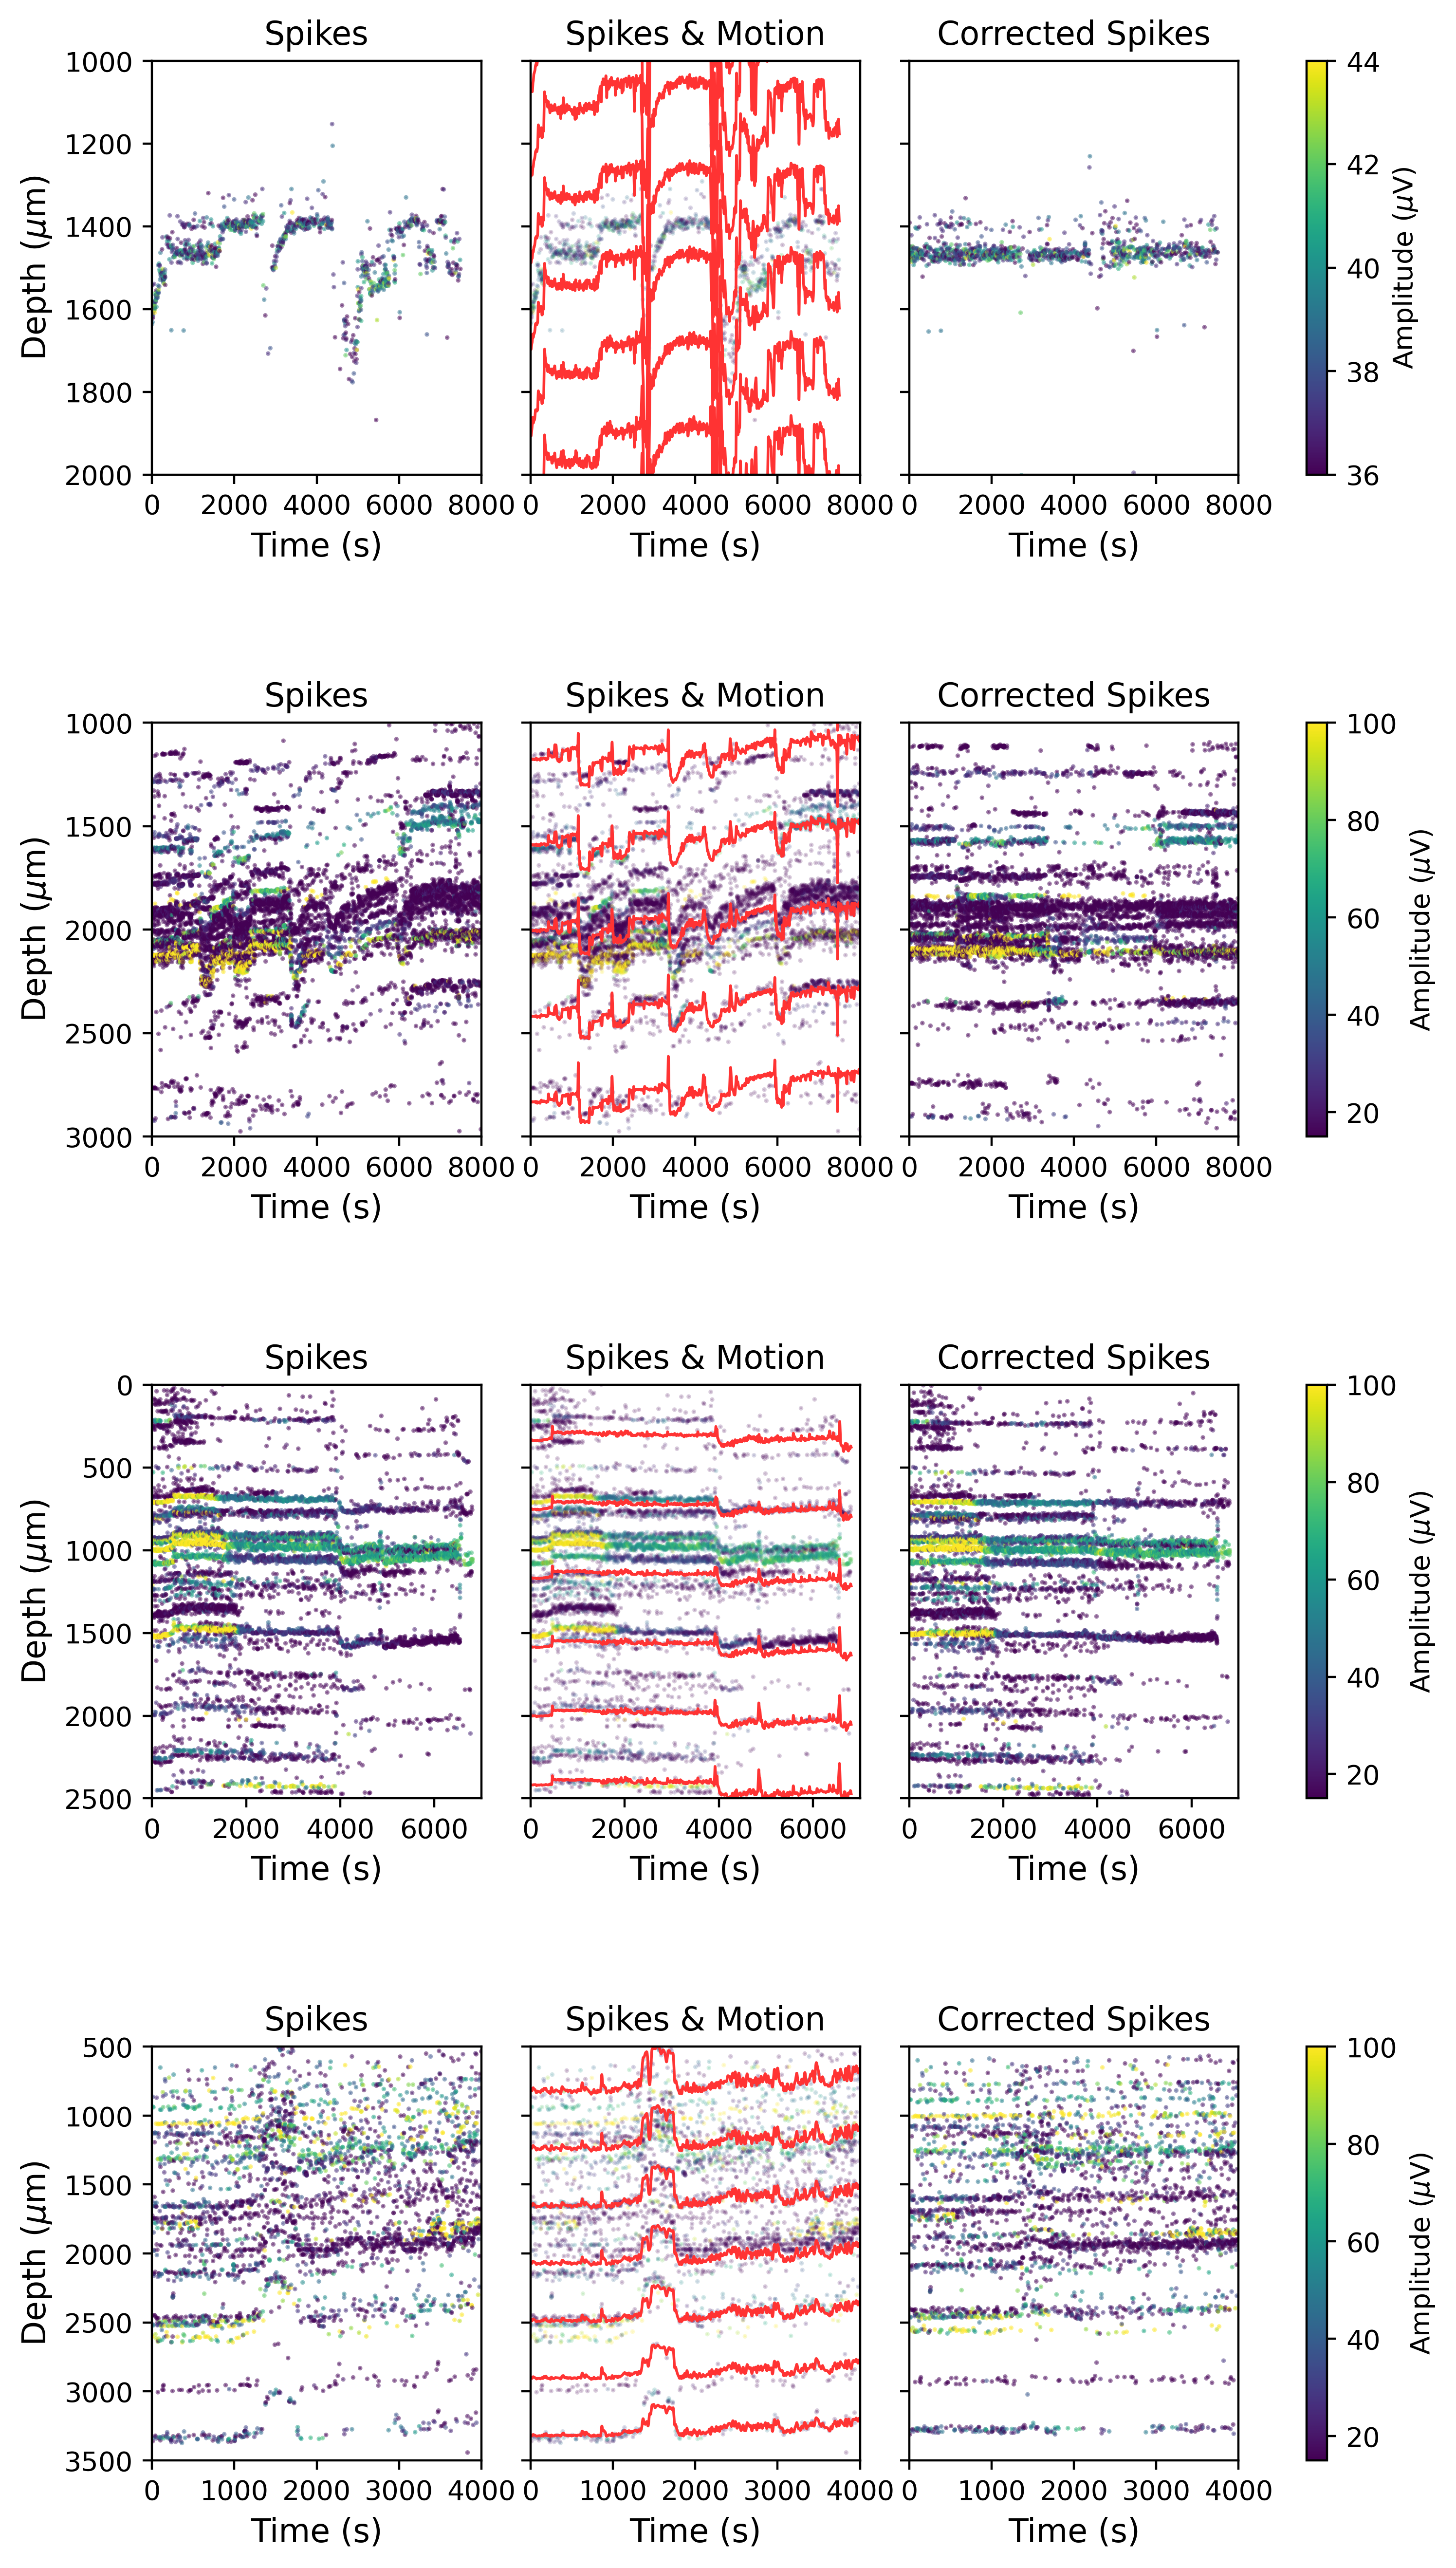

In [10]:
"""Plot spikes and motion for dataset."""

num_rows = len(DATASET_NAMES)
fig, axes = plt.subplots(
    num_rows, 3, figsize=(9, 4 * num_rows), dpi=400, sharey='row',
    gridspec_kw={'hspace': 0.6, 'wspace': 0.15},
)
for dataset_name, ax_row in zip(DATASET_NAMES, axes):
    subject, date = dataset_name.split('_')
    plot_motion(dataset_name, ax_row)
    # Add colorbar to rightmost plot in each row
    cbar = fig.colorbar(
        ax_row[0].collections[0], ax=ax_row, location='right',
        label='Amplitude ($\mu$V)',
    )
    cbar.solids.set(alpha=1)